In [1]:
%pip install lime
%pip install "numpy<2.0"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Mean Absolute Error (MAE): 0.7175105977108944
Root Mean Squared Error (RMSE): 0.9561156136107682
R-squared (R²): 0.89015012911171


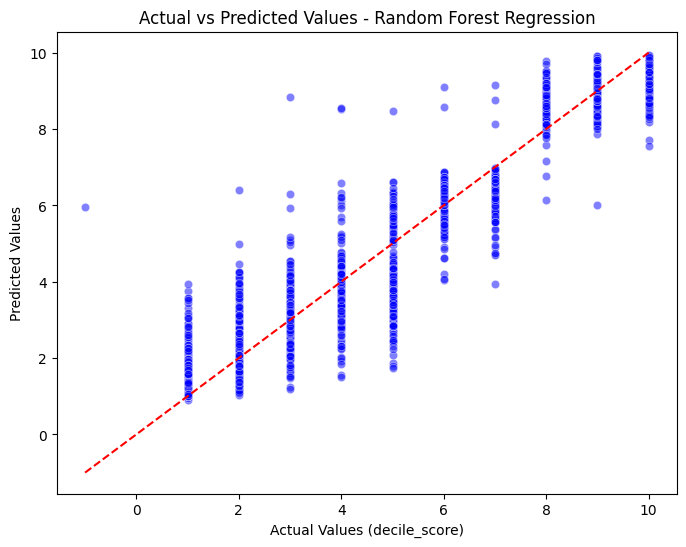

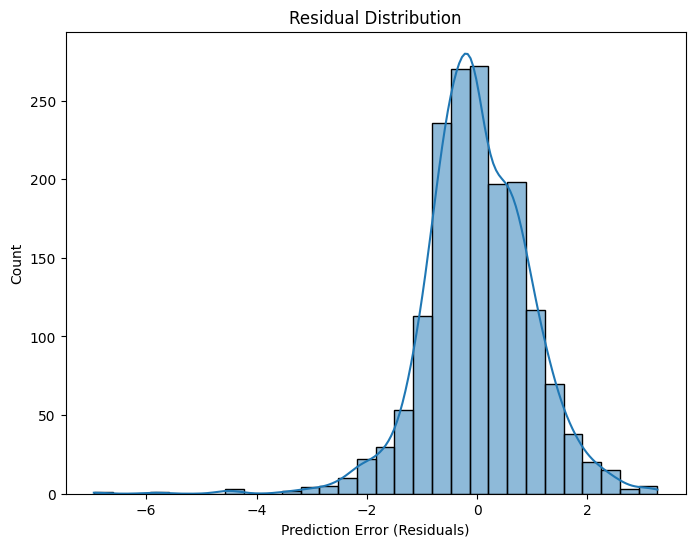

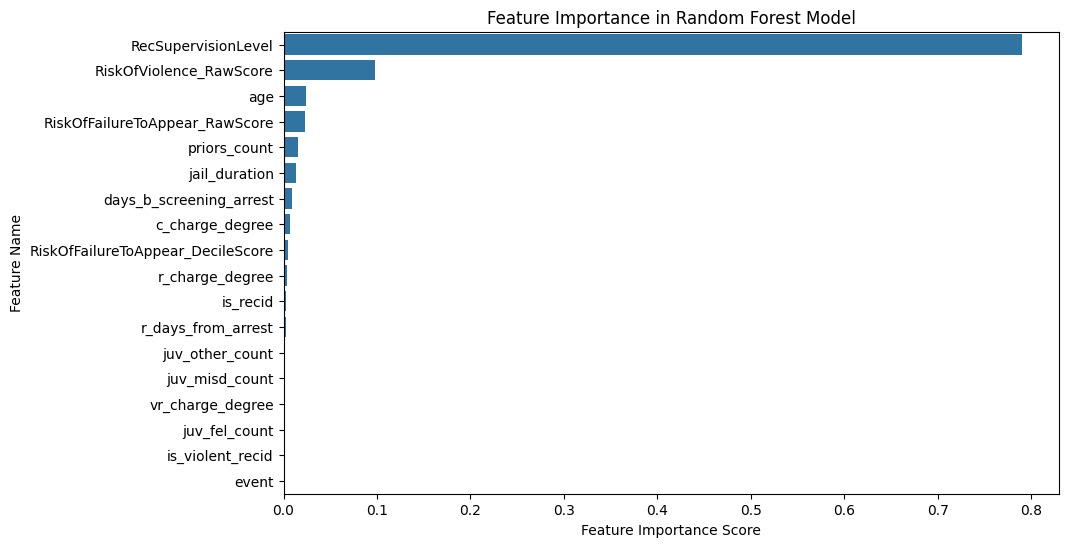

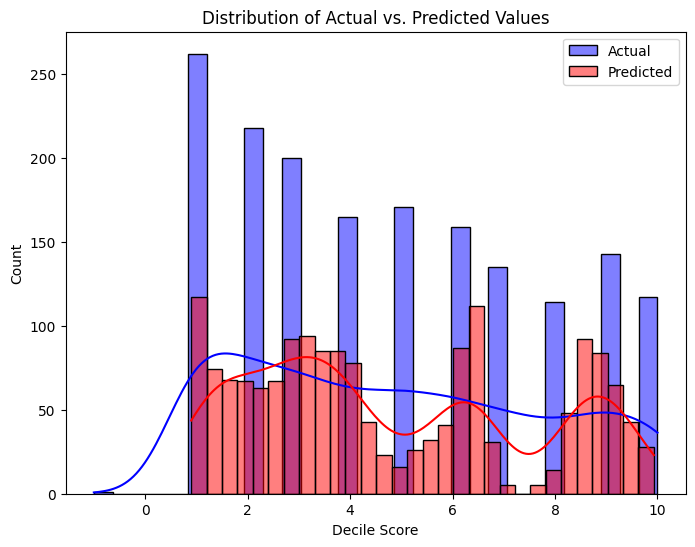

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


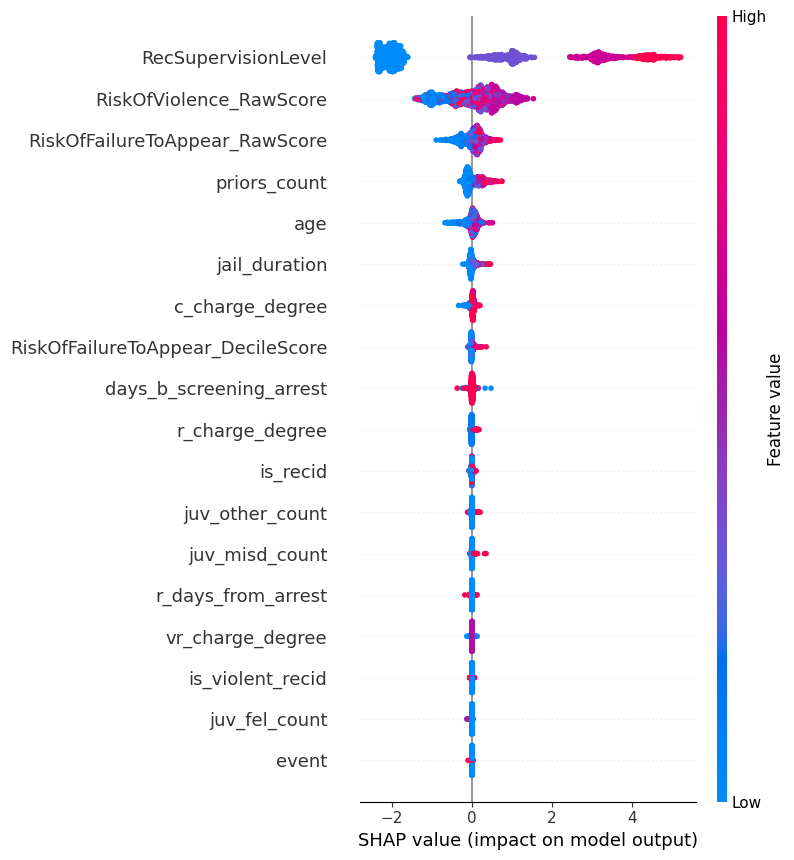

LIME encountered an error: cannot import name 'display' from 'IPython.core.display' (c:\Users\wissa\Documents\coding\Crew6\.venv\Lib\site-packages\IPython\core\display.py)


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

def load_and_preprocess_data(filepath):
    """Loads and preprocesses the COMPAS dataset."""
    df = pd.read_csv(filepath)
    df = df.drop_duplicates(subset=['FirstName', 'LastName'])
    df = df.drop([
        'r_offense_date', 'r_jail_in', 'vr_offense_date', 'screening_date',
        'score_text', 'v_score_text', 'Agency_Text', 'LastName', 'FirstName',
        'DateOfBirth', 'RecSupervisionLevelText', 'RiskOfViolence_ScoreText',
        'RiskOfRecidivism_ScoreText', 'RiskOfFailureToAppear_ScoreText',
        'RiskOfRecidivism_DecileScore', 'v_decile_score',
        'RiskOfViolence_DecileScore','RiskOfRecidivism_RawScore'
    ], axis=1)
    df = pd.get_dummies(df, columns=[
        'sex', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 'income'
    ])
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    df_numeric = df.select_dtypes(include=[np.number])
    df_numeric = df_numeric.dropna(subset=['decile_score'])
    X = df_numeric.drop(columns=['decile_score'])
    y = df_numeric['decile_score']
    return X, y

def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    """Trains a Random Forest Regressor and evaluates its performance."""
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R²): {r2}")
    return rf_model, y_pred

def visualize_results(y_test, y_pred, X_test, rf_model):
    """Visualizes the model's performance and feature importance."""
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color="blue")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel("Actual Values (decile_score)")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted Values - Random Forest Regression")
    plt.savefig("generated-images/actual_vs_predicted.png")
    plt.show()

    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, bins=30, kde=True)
    plt.xlabel("Prediction Error (Residuals)")
    plt.title("Residual Distribution")
    plt.savefig("generated-images/residual_plot.png")
    plt.show()

    importances = rf_model.feature_importances_
    feature_names = X_test.columns
    sorted_indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[sorted_indices], y=np.array(feature_names)[sorted_indices])
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Feature Name")
    plt.title("Feature Importance in Random Forest Model")
    plt.savefig("generated-images/feature_importance.png")
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.histplot(y_test, color="blue", label="Actual", kde=True, bins=30, alpha=0.5)
    sns.histplot(y_pred, color="red", label="Predicted", kde=True, bins=30, alpha=0.5)
    plt.xlabel("Decile Score")
    plt.title("Distribution of Actual vs. Predicted Values")
    plt.legend()
    plt.savefig("generated-images/histogram_actual_vs_predicted.png")
    plt.show()

    explainer_shap = shap.TreeExplainer(rf_model)
    shap_values = explainer_shap.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.savefig("generated-images/shap_summary.png")
    plt.show()

    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        X_train.values, feature_names=X_test.columns, mode='regression',
        discretize_continuous=False)

    def explain_instance(index, model):
        exp = explainer_lime.explain_instance(X_test.iloc[index].values,
                                                model.predict)
        exp.show_in_notebook()

    try:
        explain_instance(0, rf_model)
    except Exception as e:
        print(f"LIME encountered an error: {e}")

# Main execution
filepath = 'datasets/final-preprocessed-imputed-compas-df.csv'
X, y = load_and_preprocess_data(filepath)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
rf_model, y_pred = train_and_evaluate_model(X_train, X_test, y_train, y_test)
visualize_results(y_test, y_pred, X_test, rf_model)